In [1]:
# In this Notebook I show that converting a normal feedforward net to a FGN is easy
# (first over a toy 2D dataset)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

countdown               Fri Jul 10 16:40:02 2020  418.87.01
[0] GeForce RTX 2080 Ti | 52'C,   0 % |  5246 / 10989 MB | felix(5235M)
[1] GeForce RTX 2080 Ti | 50'C,   0 % |   956 / 10988 MB | felix(775M) root(169M)


In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device

torch.cuda.set_device(1)

CUDA Available:  True
Using device: cpu


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
total_num_samples = 5000

# random moons
samples, labels = datasets.make_moons(n_samples=total_num_samples, noise=0.2, shuffle=True)

# random concentric circles
# samples, labels = datasets.make_circles(n_samples=total_num_samples, noise=0.08, factor=0.4, shuffle=True)

scaler = StandardScaler()
scaler.fit(samples)

samples = scaler.transform(samples)

# train/test split
ratio=4.0/5.0
split_index = int(len(samples)*ratio)
    
train_samples, train_labels = samples[:split_index], labels[:split_index]
test_samples, test_labels = samples[split_index:], labels[split_index:]

num_samples = len(train_samples)

<IPython.core.display.Javascript object>


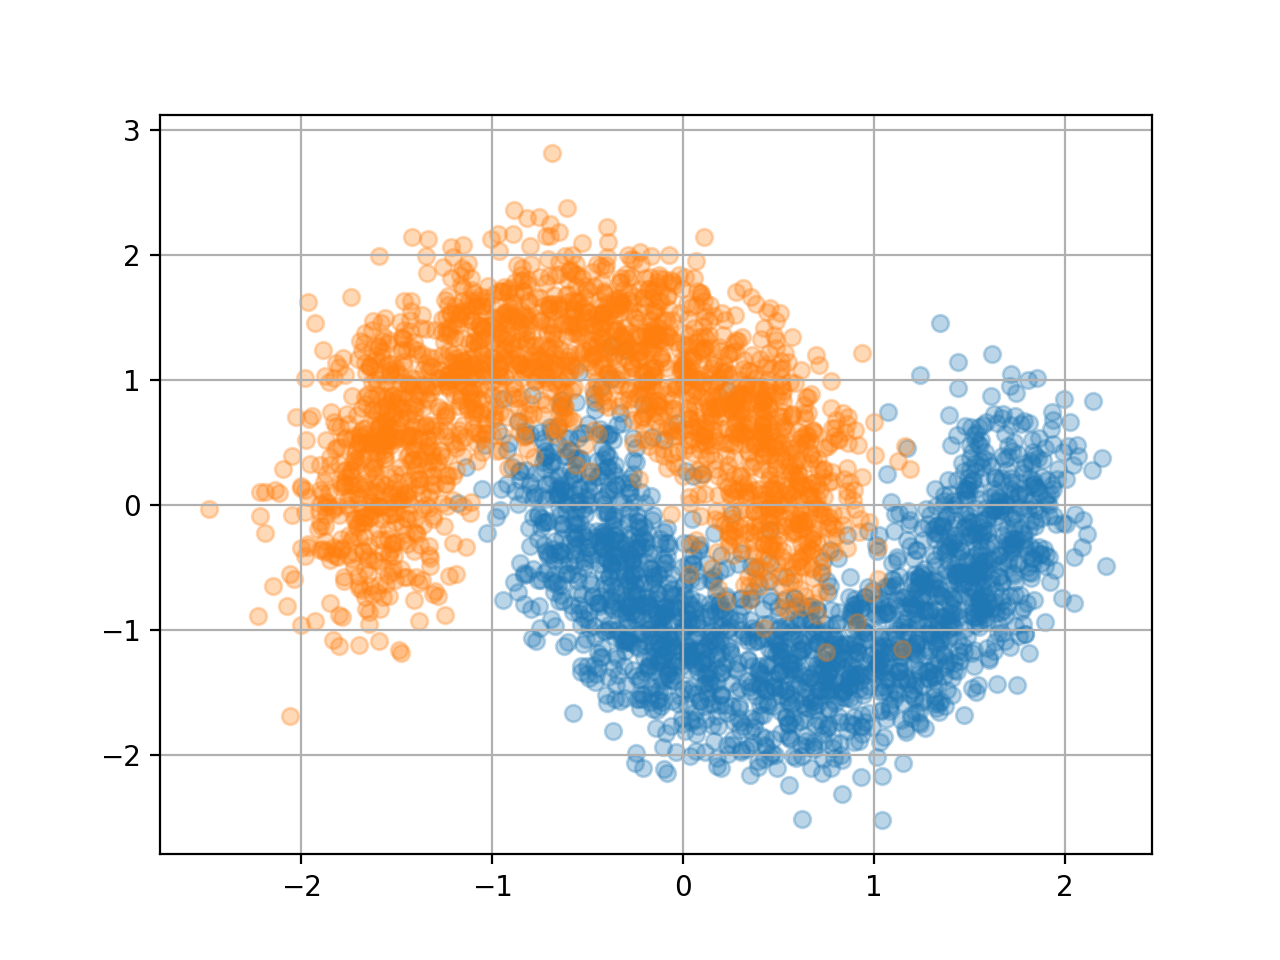

In [9]:
# 2D Check 
samples_x_1 = [x for x,l in zip(train_samples[:,0], train_labels) if l==0]
samples_y_1 = [y for y,l in zip(train_samples[:,1], train_labels) if l==0]

samples_x_2 = [x for x,l in zip(train_samples[:,0], train_labels) if l==1]
samples_y_2 = [y for y,l in zip(train_samples[:,1], train_labels) if l==1]


plt.scatter(samples_x_2, samples_y_2, alpha=0.3)
plt.scatter(samples_x_1, samples_y_1, alpha=0.3)
plt.grid(True)
plt.show()

In [10]:
# convert data to pytorch format 
tensor_train_x = torch.Tensor(train_samples)
tensor_train_y = torch.Tensor(train_labels)

tensor_test_x = torch.Tensor(test_samples)
tensor_test_y = torch.Tensor(test_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_train_x, tensor_train_y, ) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_test_x,tensor_test_y) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=512, shuffle=True) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data, batch_size=1000, shuffle=True) # create your dataloader

In [11]:
# loss functions for the classic net
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
print("lambda for l2:", lmbda_l2)
      
classical_cross_ent_loss = fgnh.def_classical_cross_ent_loss(lmbda_l2)

lambda for l2: 0.0001


In [12]:
# Initialize the classic network
hidden_layer_sizes = [10,10]
drop_p = 0.1

In [13]:
classic_model = fgnl.Feedforward_Classic_net(in_feats=2, out_feats=2, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p)
classic_model.to(device)

Feedforward_Classic_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=2, out_features=10, bias=True)
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.1, inplace=False)
  )
  (ib): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Linear(in_features=10, out_features=2, bias=True)
)

In [14]:
classic_optimizer = optim.Adam(filter(lambda p: p.requires_grad, classic_model.parameters()), lr=0.03)
# classic_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, classic_model.parameters()))

In [15]:
epochs = 50

In [16]:
classic_train_res = fgnh.train(classic_model, my_dataloader, 
                             classical_cross_ent_loss, classic_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 0.4076, Accuracy: 3230/4000 (81%)
Test set - Average loss: 0.3164, Accuracy: 871/1000 (87%)
Epoch 1 Train set - Average loss: 0.3258, Accuracy: 3418/4000 (85%)
Test set - Average loss: 0.4130, Accuracy: 835/1000 (84%)
Epoch 2 Train set - Average loss: 0.2921, Accuracy: 3494/4000 (87%)
Test set - Average loss: 0.3881, Accuracy: 832/1000 (83%)
Epoch 3 Train set - Average loss: 0.2562, Accuracy: 3561/4000 (89%)
Test set - Average loss: 0.4153, Accuracy: 791/1000 (79%)
Epoch 4 Train set - Average loss: 0.2405, Accuracy: 3599/4000 (90%)
Test set - Average loss: 0.3767, Accuracy: 816/1000 (82%)
Epoch 5 Train set - Average loss: 0.2268, Accuracy: 3624/4000 (91%)
Test set - Average loss: 0.1928, Accuracy: 946/1000 (95%)
Epoch 6 Train set - Average loss: 0.2362, Accuracy: 3612/4000 (90%)
Test set - Average loss: 0.1778, Accuracy: 941/1000 (94%)
Epoch 7 Train set - Average loss: 0.2341, Accuracy: 3587/4000 (90%)
Test set - Average loss: 0.1545, Accuracy: 946/100

<IPython.core.display.Javascript object>


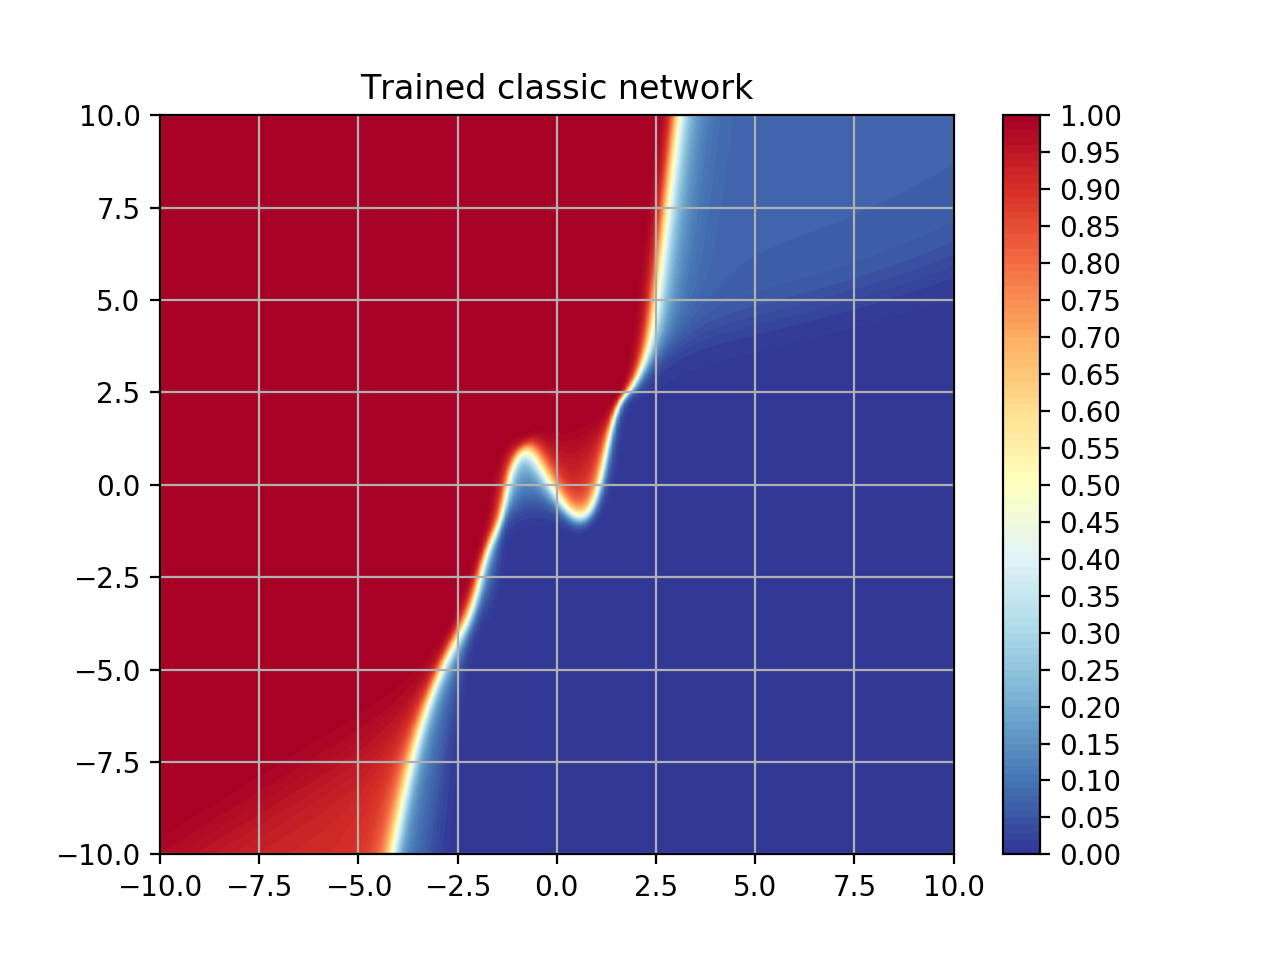

In [17]:
fgnh.plot_2D_heatmap(classic_model, scale=10.,  type='first', show_data=False,
                     title="Trained classic network")

In [18]:
### FGN NETWORK

In [19]:
# Initialize the fgn network
print('hidden layers:', hidden_layer_sizes)
print('drop prob:', drop_p)
# fgn specific params
covar_type = 'sphere'
print('covariance:', covar_type)
ordinal = float(5)
print('ordinal: {0:.10f}'.format(ordinal))
non_lin = True
# non_lin = False
print('non linearity:', non_lin)
free_biases=True
print('Free biases:', free_biases)

hidden layers: [10, 10]
drop prob: 0.1
covariance: sphere
ordinal: 5.0000000000
non linearity: True
Free biases: True


In [20]:
fgn_model = fgnl.Feedforward_FGN_net(in_feats=2, out_feats=2, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal, non_lin=non_lin, free_biases=free_biases)

fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.1, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.1, inplace=False)
  )
  (ib): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [21]:
# What is the activity of the FGN before conversion?
_ = fgnh.test(fgn_model, my_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, my_test_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)



# print("With random eval ON")
# fgn_model.set_random_eval(True)
# _ = fgnh.test(fgn_model, my_dataloader,
#                         classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

# _ = fgnh.test(fgn_model, my_test_dataloader,
#                         classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.6956, Accuracy: 1951/4000 (49%)
Test set - Average loss: 0.6943, Accuracy: 489/1000 (49%)


<IPython.core.display.Javascript object>


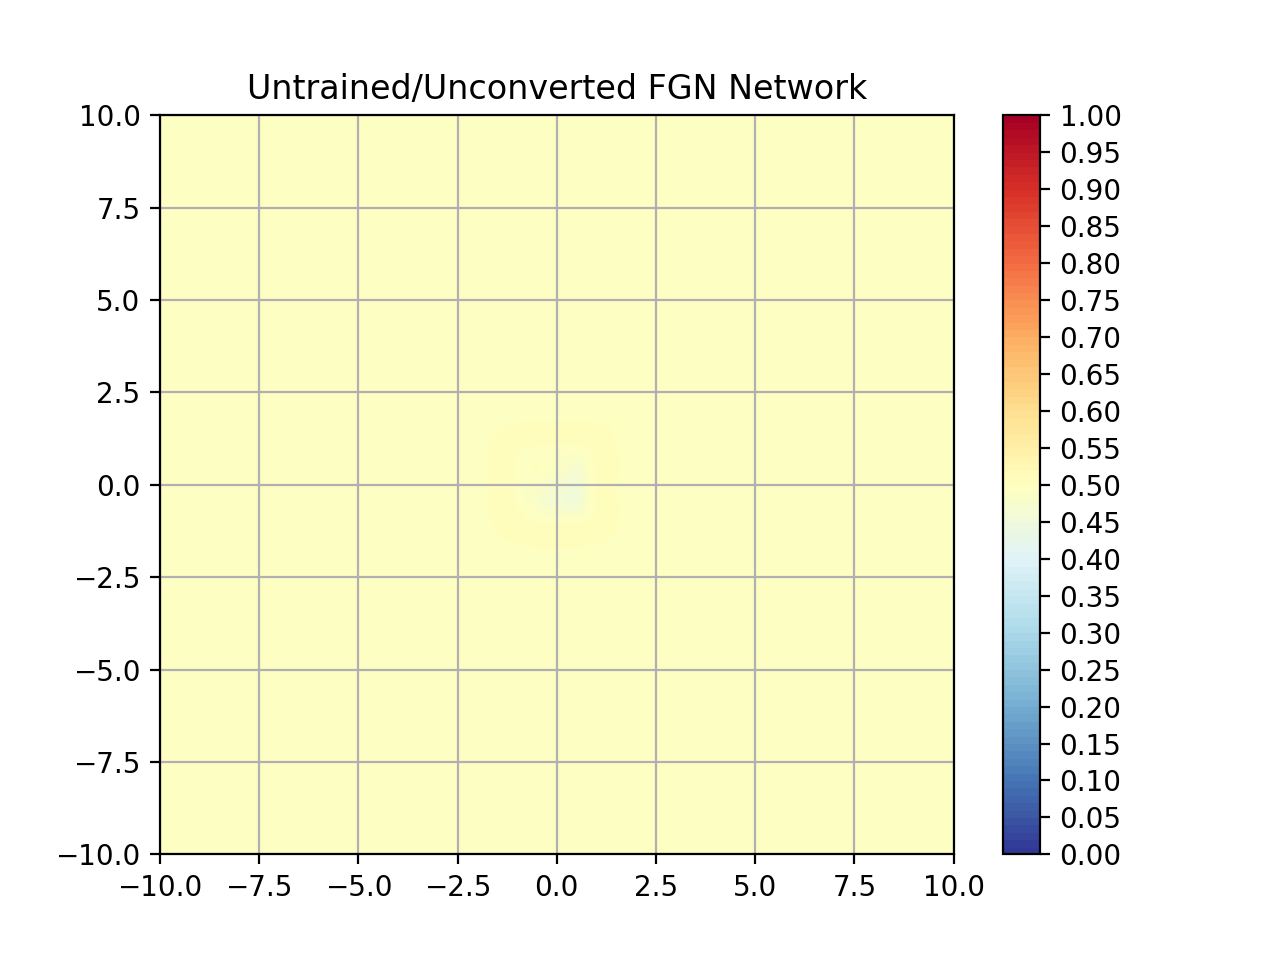

In [22]:
fgnh.plot_2D_heatmap(fgn_model, scale=10.,  type='first', show_data=False,
                     title='Untrained/Unconverted FGN Network')

In [23]:
# convert from classic network
fgnl.convert_classic_to_fgn(classic_model, fgn_model, init_factor=20)

In [24]:
# check perfomance, should be close to that of classic network, identical if non_lin = tanh is used
fgn_model.set_random_eval(False)
_ = fgnh.test(fgn_model, my_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, my_test_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

# # random eval should be same as above because of large sigmas
# print("With random eval ON")
# fgn_model.set_random_eval(True)
# _ = fgnh.test(fgn_model, my_dataloader,
#                         classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

# _ = fgnh.test(fgn_model, my_test_dataloader,
#                         classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.1609, Accuracy: 3786/4000 (95%)
Test set - Average loss: 0.1787, Accuracy: 935/1000 (94%)


<IPython.core.display.Javascript object>


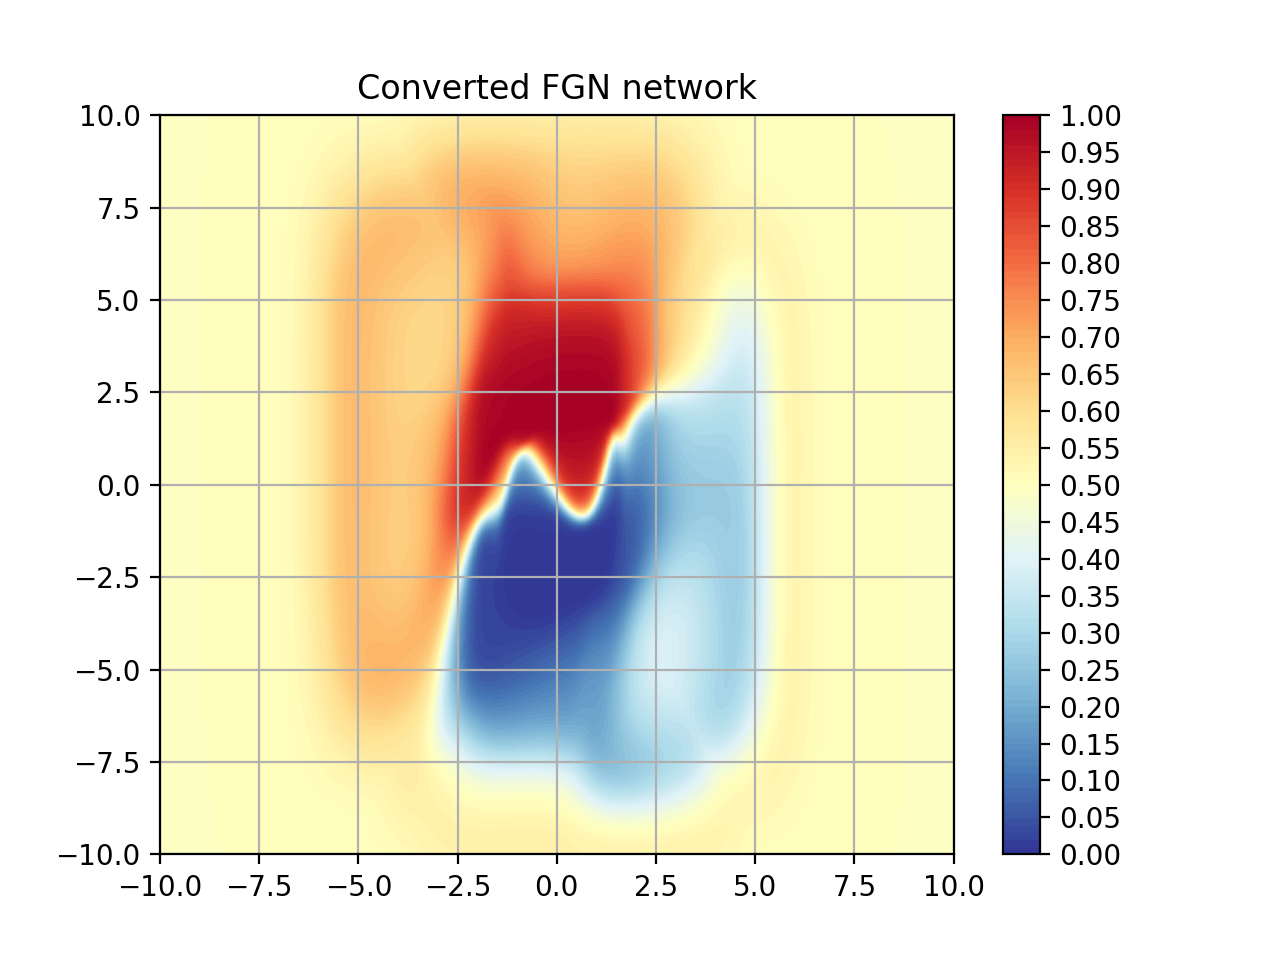

<IPython.core.display.Javascript object>


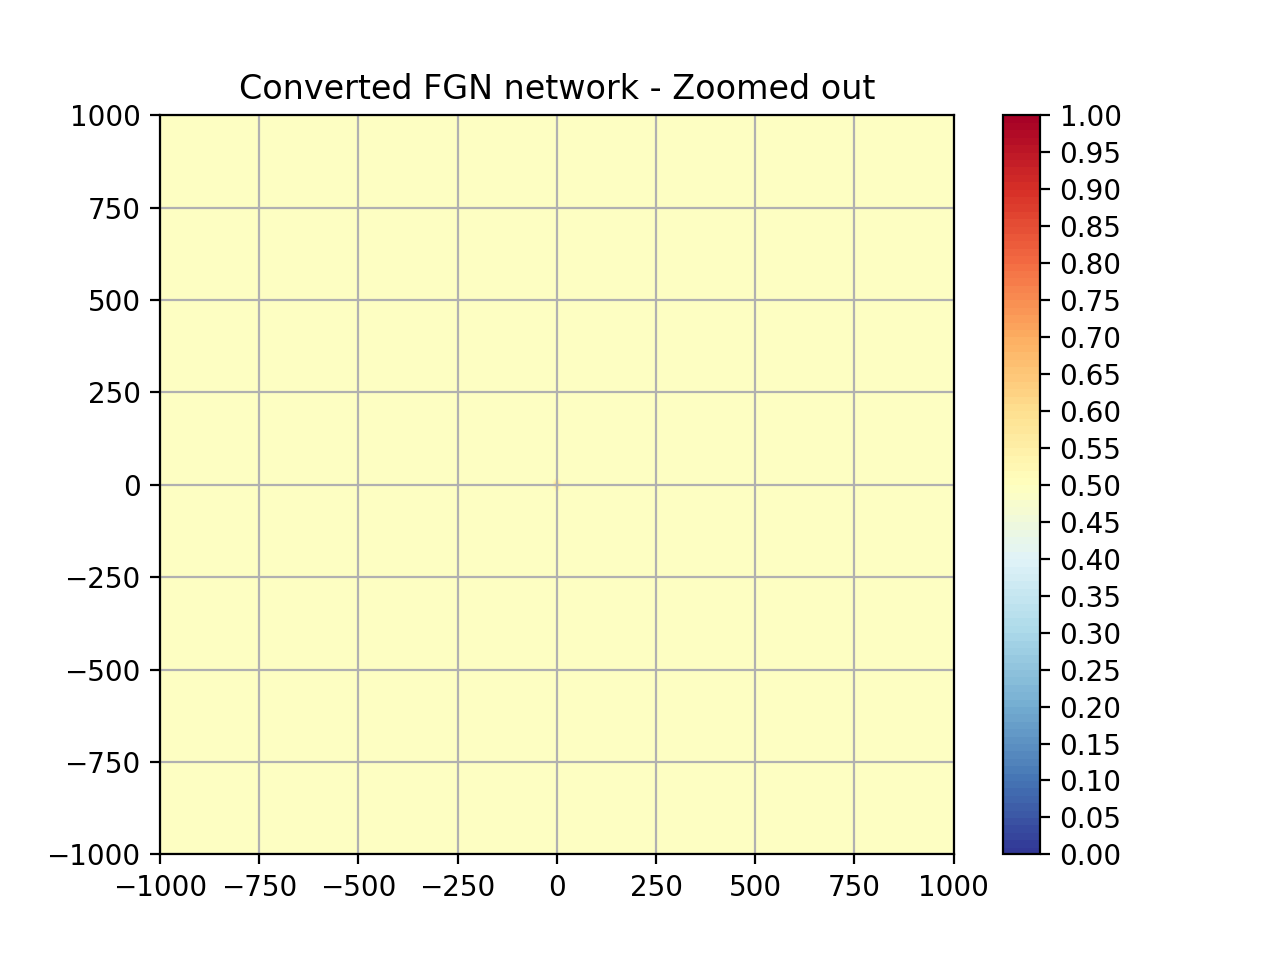

In [25]:
fgnh.plot_2D_heatmap(fgn_model, title="Converted FGN network", scale=10.,  type='first',
                     show_data=False)
fgnh.plot_2D_heatmap(fgn_model, title="Converted FGN network - Zoomed out", scale=1000.,  type='first',
                     show_data=False)

In [26]:
# # old random eval code

# fgn_model.set_random_eval(True)
# fgnh.plot_2D_heatmap(fgn_model, title="Converted FGN network - random eval ON")
# fgnh.plot_2D_heatmap(fgn_model, title="Converted FGN network - random eval ON \n Zoomed out", scale=100.0)
# fgnh.plot_2D_heatmap(fgn_model, title="Converted FGN network - random eval ON \n Super Zoomed out", scale=100000.0)


In [27]:
### PART 2 - shrink sigmas

In [28]:
# adjusts sigmas and centers
# - should be fast (one epoch)
# - shouldn't impact accuracy

In [29]:
# method one: train with CENT loss but only adjust sigmas? sigmas and center? all params?

In [30]:
# # only train inv_covar and centers
# adjust_sigmas_optimizer = optim.Adam(zip(*filter(lambda p: p[1].requires_grad and 
#                                                  ('inv_covars' in p[0] or 'centers' in p[0]), 
#                                                  fgn_model.named_parameters()))[1])

# adjust_sigmas_optimizer = optim.RMSprop(zip(*filter(lambda p: p[1].requires_grad and 
#                                                     ('inv_covars' in p[0] or 'centers' in p[0]), 
#                                                  fgn_model.named_parameters()))[1])

# adjust_sigmas_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()), lr=0.05, momentum=0.1)

adjust_sigmas_optimizer = optim.Adam(filter(lambda p: p.requires_grad, fgn_model.parameters()), lr=0.001)

lmbda_sigs = 0.00001
adjust_sigmas_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2=0.0, lmbda_sigs=lmbda_sigs)

In [31]:
converted_train_res = fgnh.train(fgn_model, my_dataloader, 
                             adjust_sigmas_loss, adjust_sigmas_optimizer, epochs=10, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 0.4685, Accuracy: 3597/4000 (90%)
Test set - Average loss: 0.3023, Accuracy: 938/1000 (94%)
Epoch 1 Train set - Average loss: 0.3851, Accuracy: 3593/4000 (90%)
Test set - Average loss: 0.2646, Accuracy: 938/1000 (94%)
Epoch 2 Train set - Average loss: 0.3485, Accuracy: 3618/4000 (90%)
Test set - Average loss: 0.2565, Accuracy: 939/1000 (94%)
Epoch 3 Train set - Average loss: 0.3319, Accuracy: 3628/4000 (91%)
Test set - Average loss: 0.2421, Accuracy: 941/1000 (94%)
Epoch 4 Train set - Average loss: 0.3262, Accuracy: 3629/4000 (91%)
Test set - Average loss: 0.2318, Accuracy: 942/1000 (94%)
Epoch 5 Train set - Average loss: 0.3041, Accuracy: 3653/4000 (91%)
Test set - Average loss: 0.2205, Accuracy: 942/1000 (94%)
Epoch 6 Train set - Average loss: 0.3180, Accuracy: 3607/4000 (90%)
Test set - Average loss: 0.2139, Accuracy: 945/1000 (94%)
Epoch 7 Train set - Average loss: 0.2850, Accuracy: 3666/4000 (92%)
Test set - Average loss: 0.2062, Accuracy: 946/100

In [32]:
# check accuracy with both non-random and random eval
# fgn_model.set_random_eval(False)
_ = fgnh.test(fgn_model, my_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, my_test_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

# fgn_model.set_random_eval(True)
# _ = fgnh.test(fgn_model, my_dataloader,
#                         classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

# _ = fgnh.test(fgn_model, my_test_dataloader,
#                         classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.1094, Accuracy: 3861/4000 (97%)
Test set - Average loss: 0.1320, Accuracy: 949/1000 (95%)


<IPython.core.display.Javascript object>


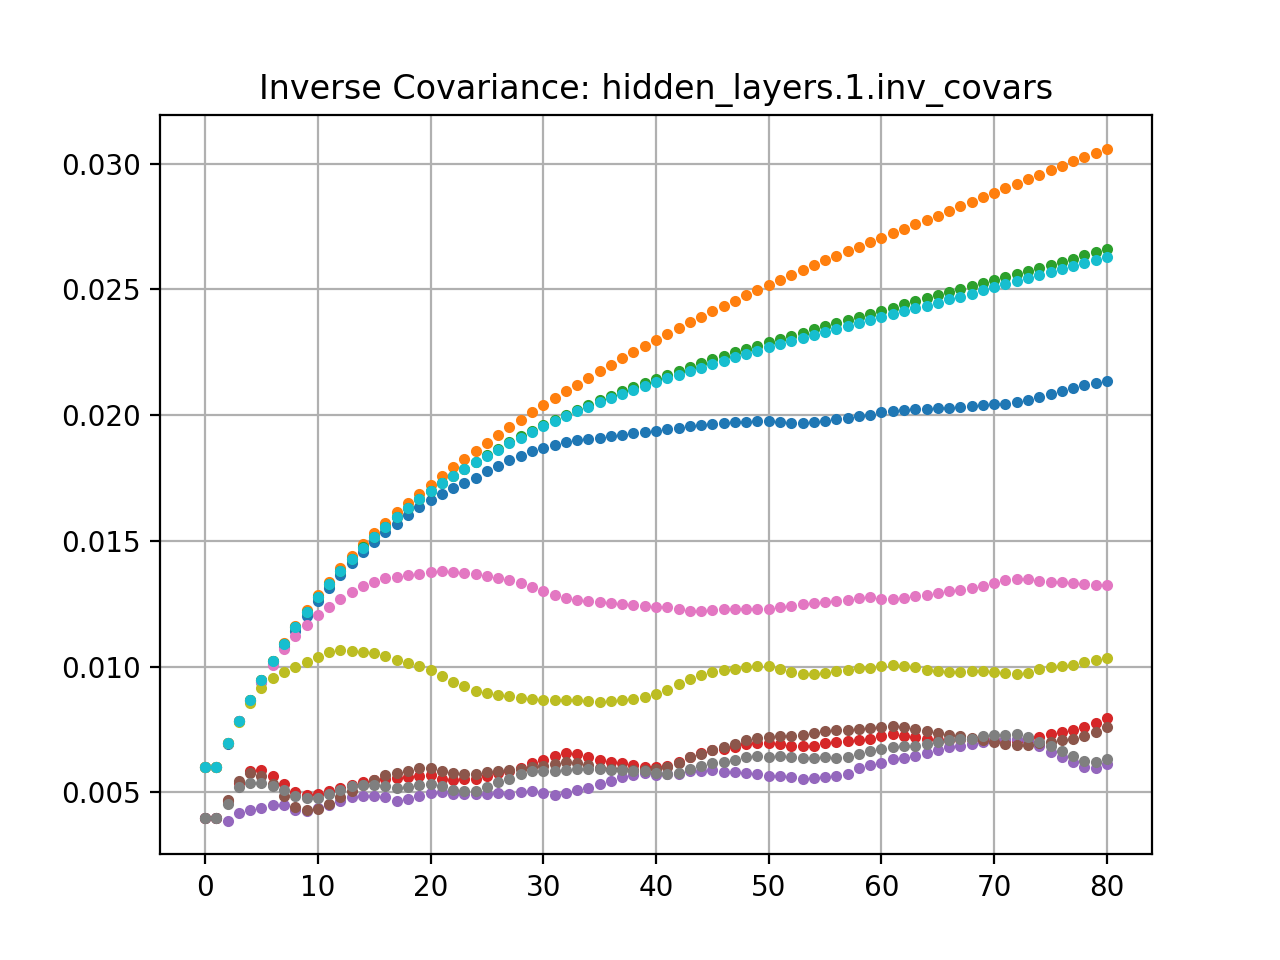

<IPython.core.display.Javascript object>


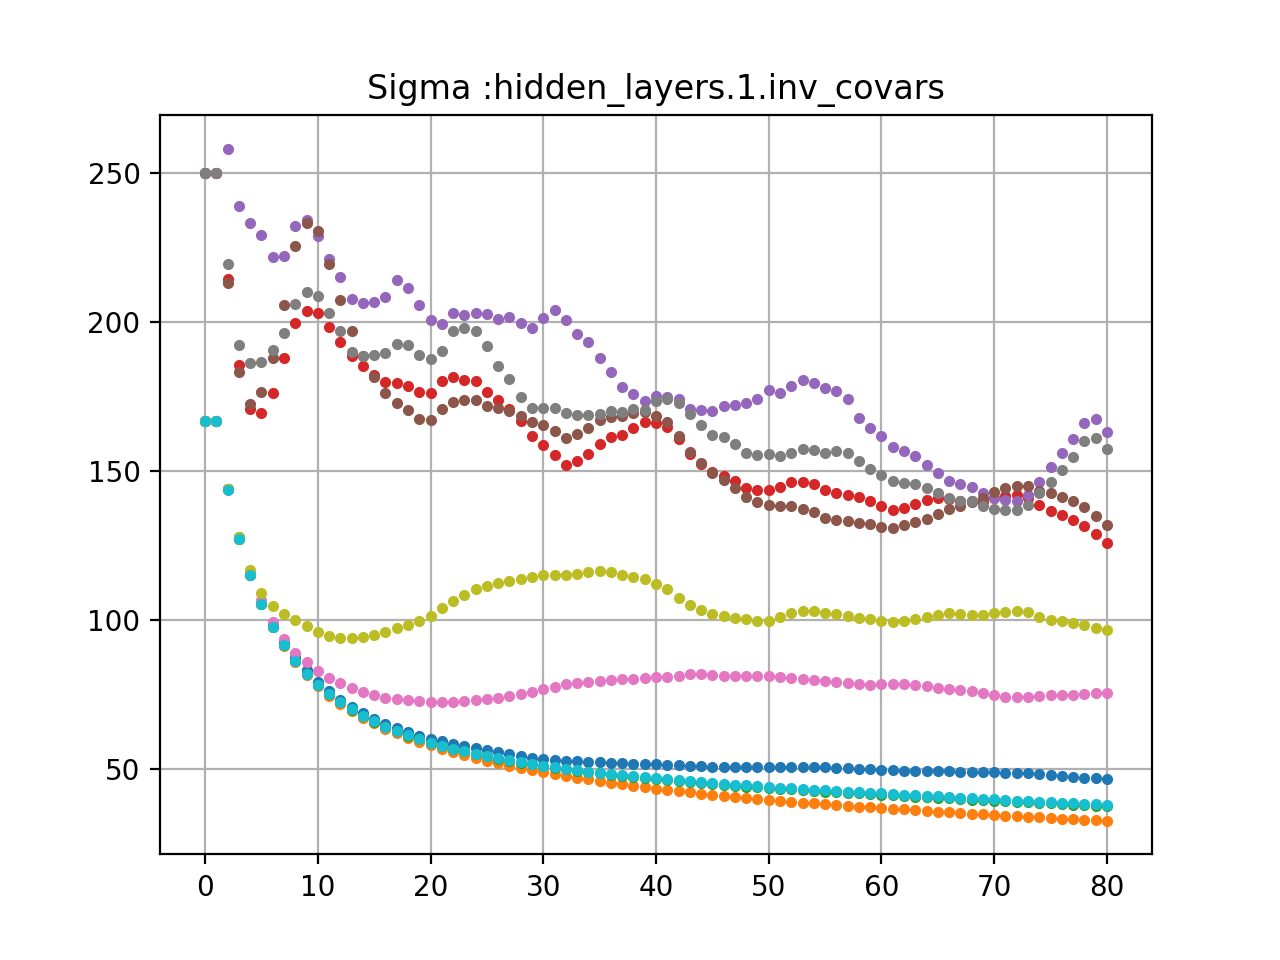

<IPython.core.display.Javascript object>


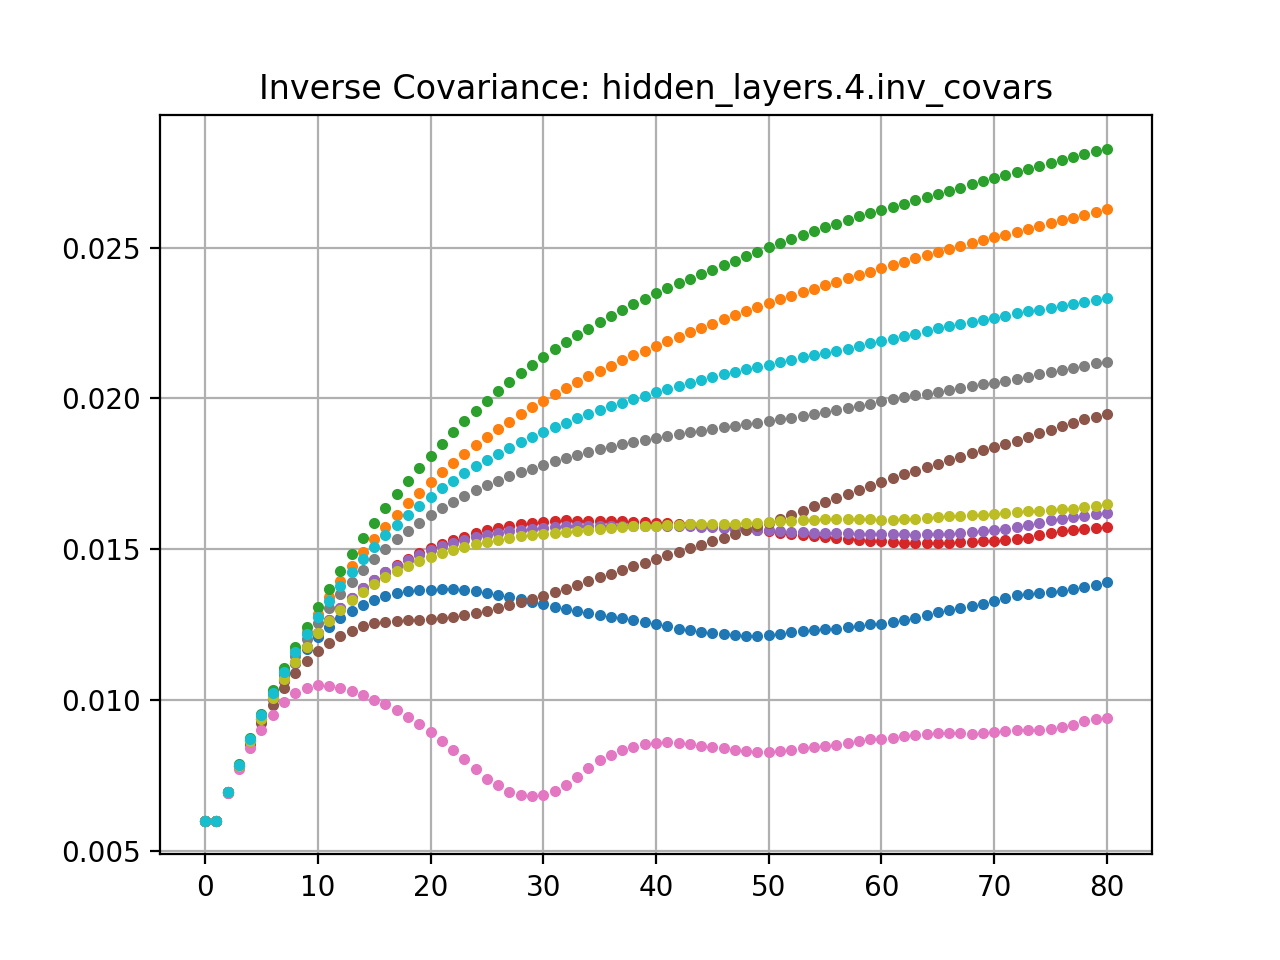

<IPython.core.display.Javascript object>


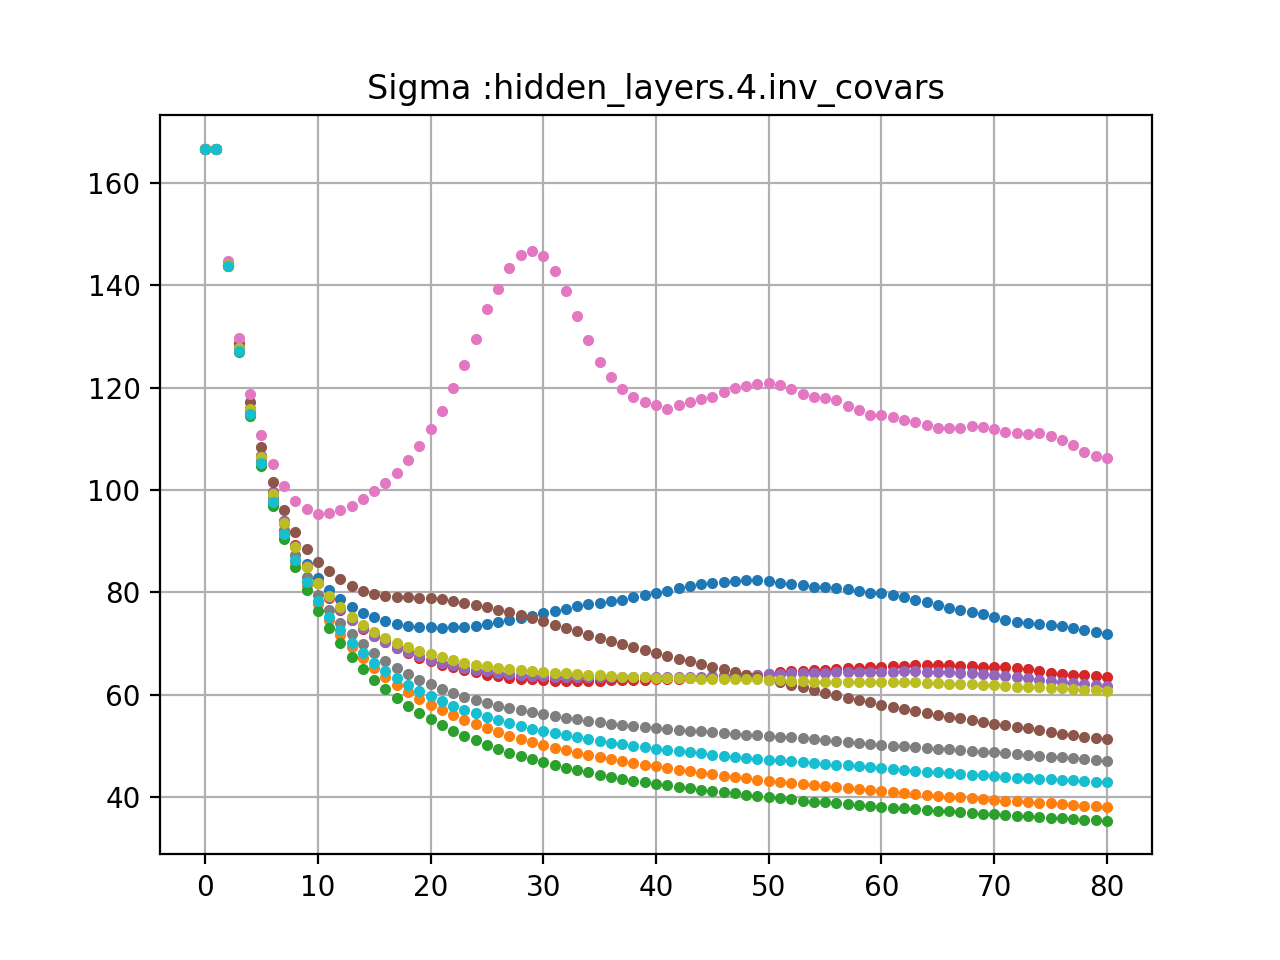

<IPython.core.display.Javascript object>


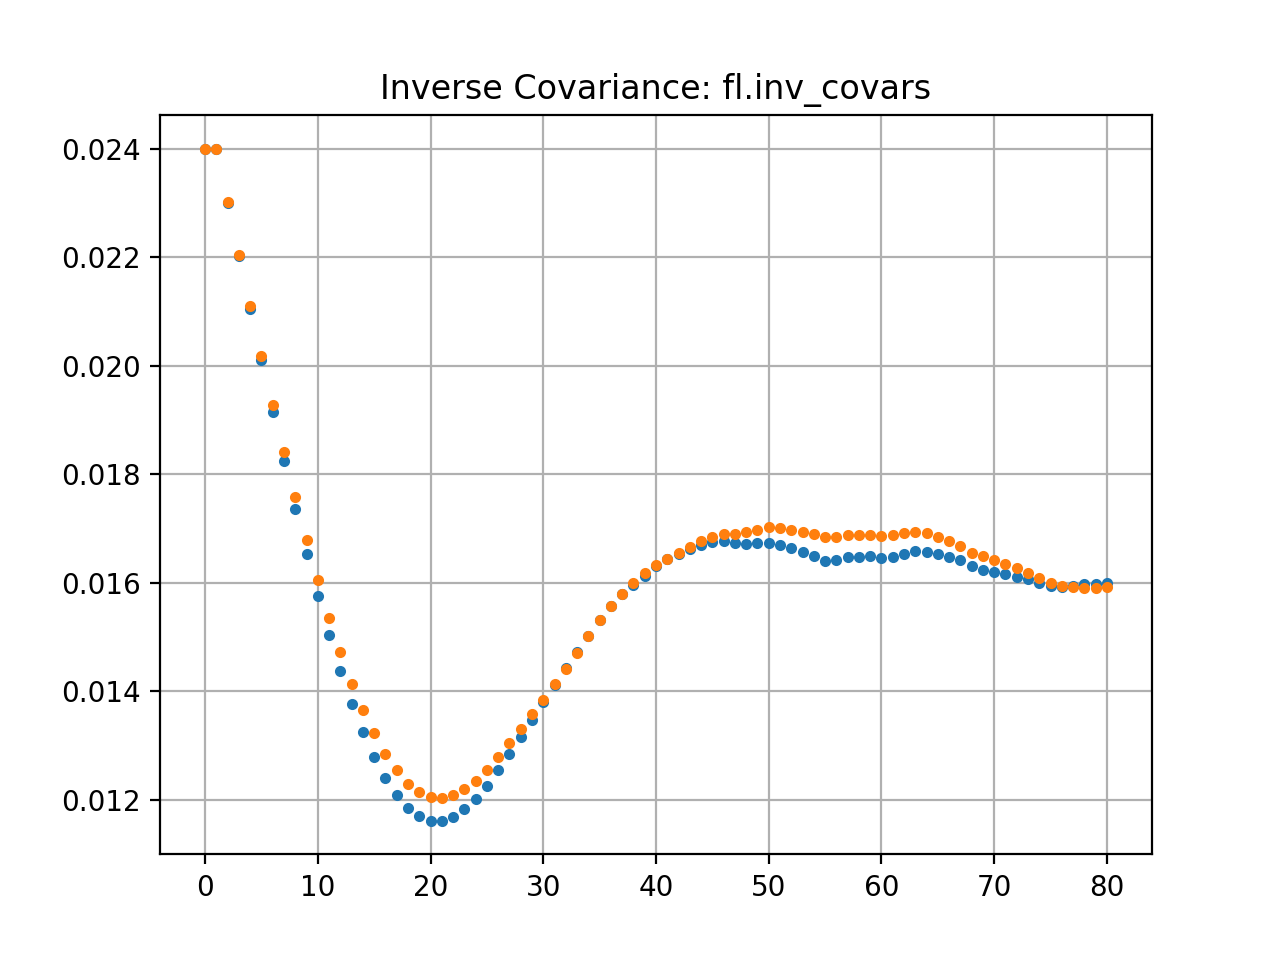

<IPython.core.display.Javascript object>


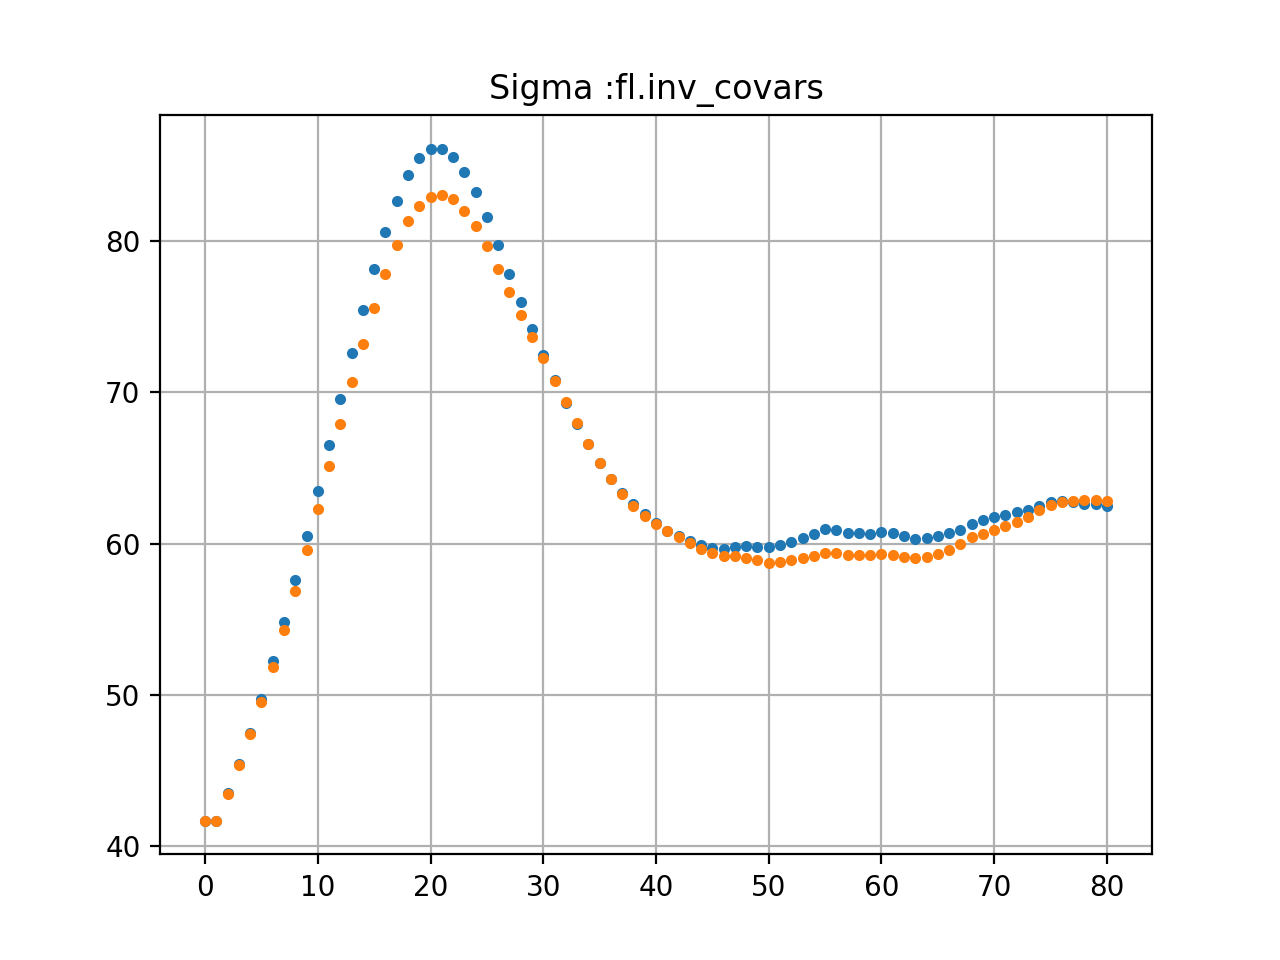

In [33]:
# # check that inv covar has gone up, sigmas down, and trace down if covar_type=='full'
fgnl.plot_sigmas_histories(converted_train_res['histories'], covar_type=covar_type)

<IPython.core.display.Javascript object>


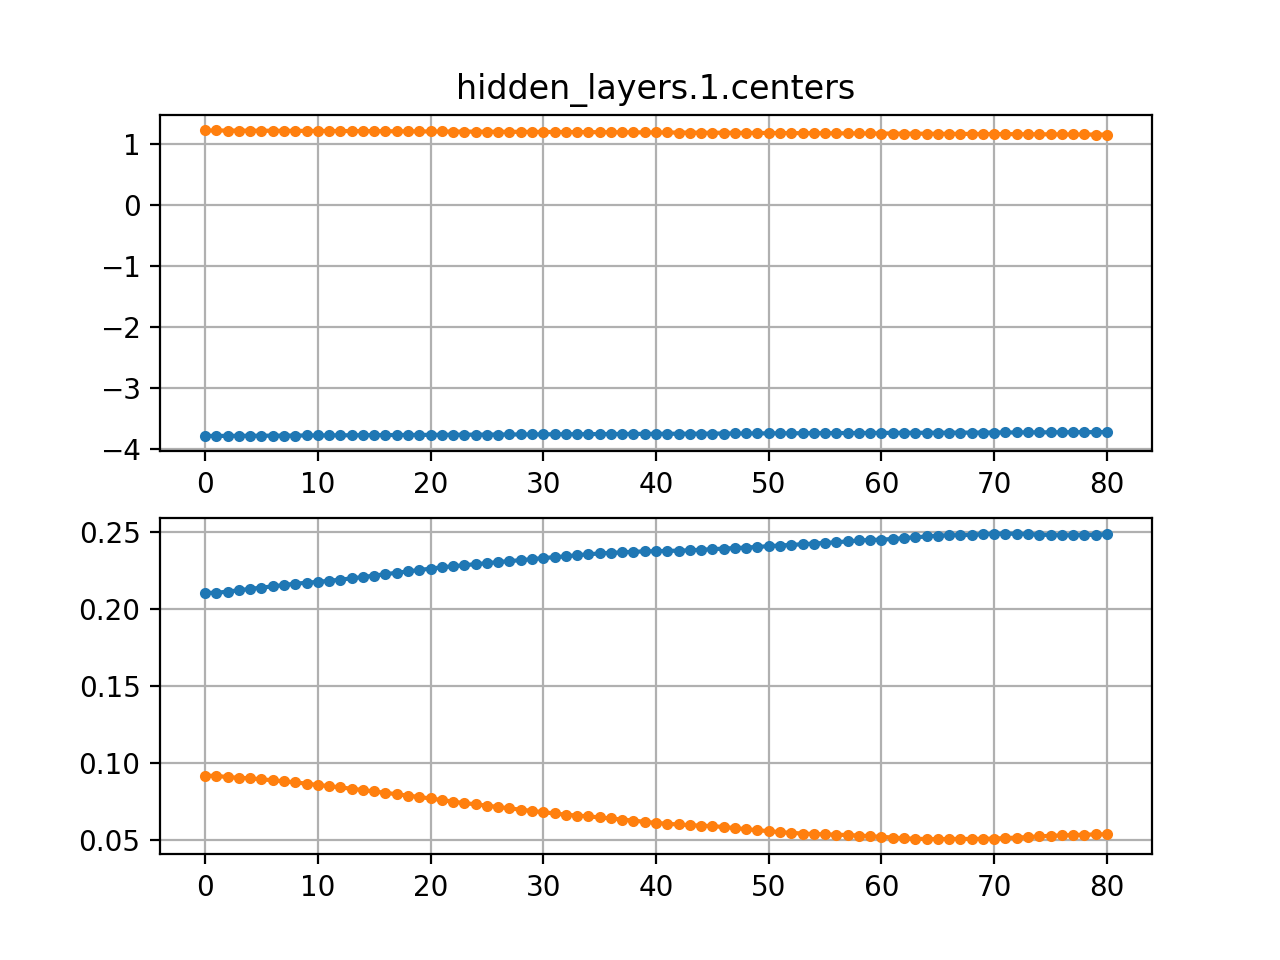

<IPython.core.display.Javascript object>


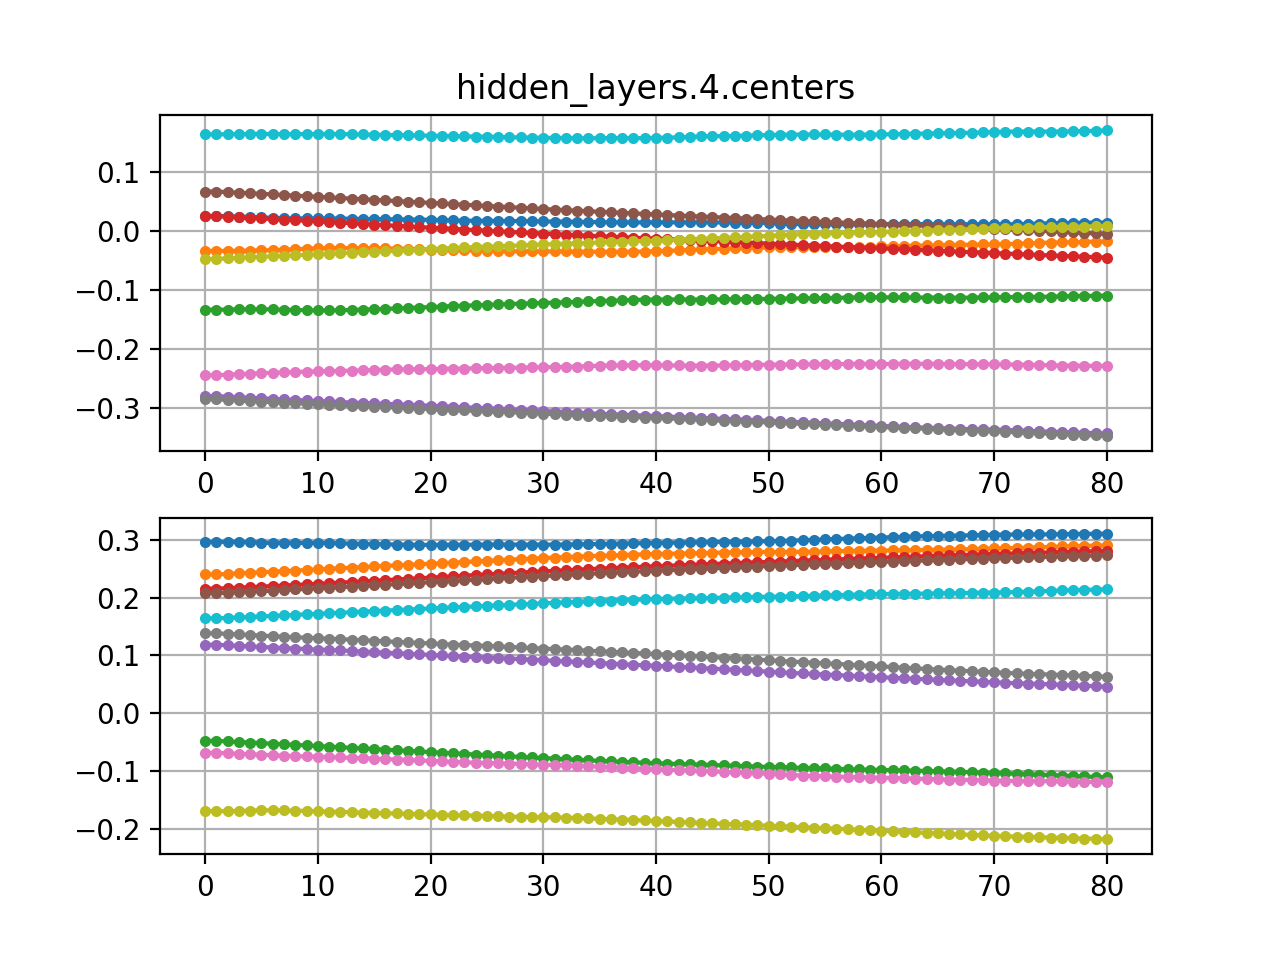

<IPython.core.display.Javascript object>


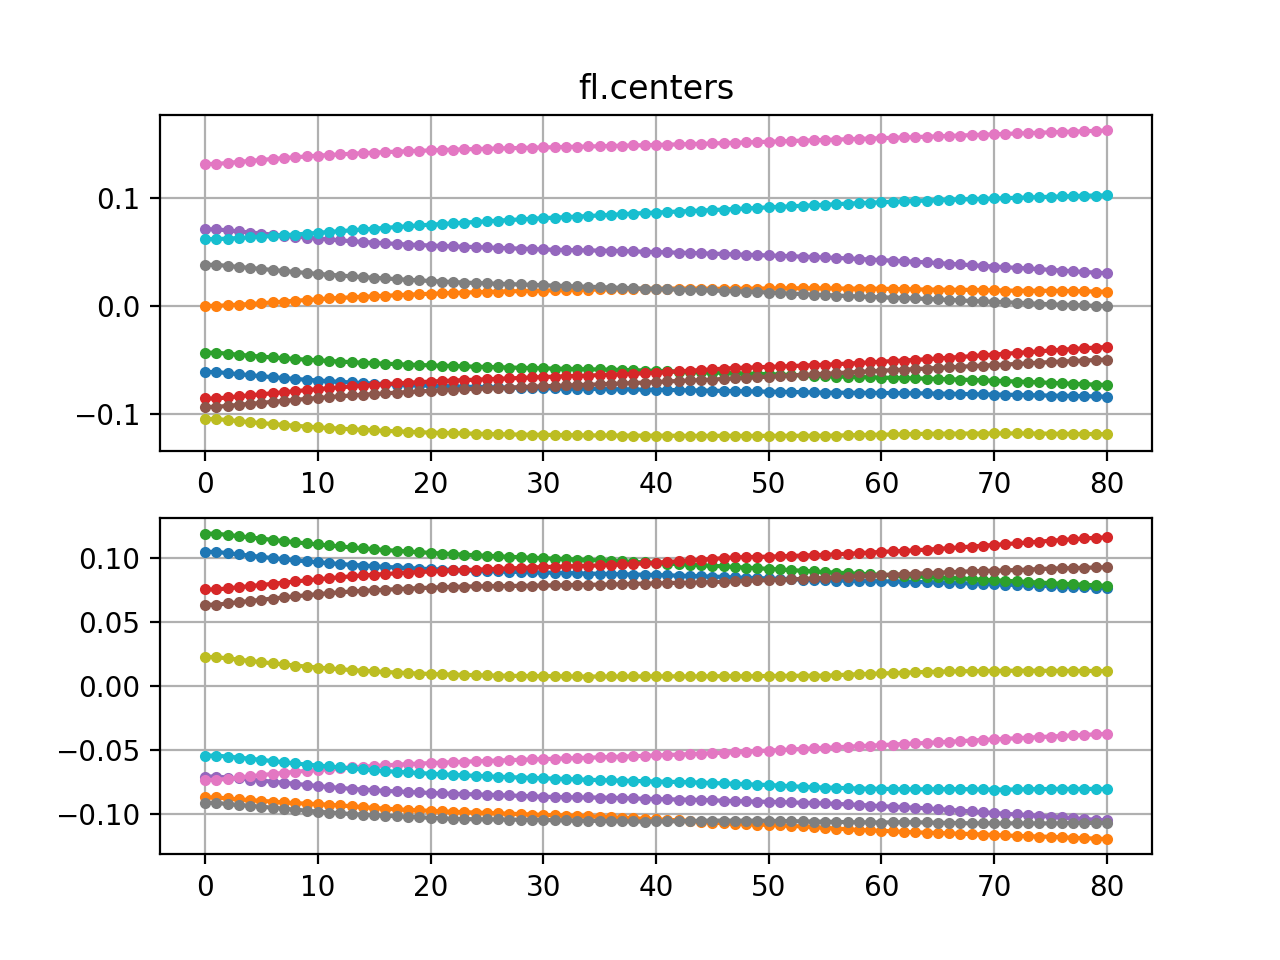

In [34]:
# plot centers history for only some hidden layer neuron
fgnl.plot_centers_histories(converted_train_res['histories'])

<IPython.core.display.Javascript object>


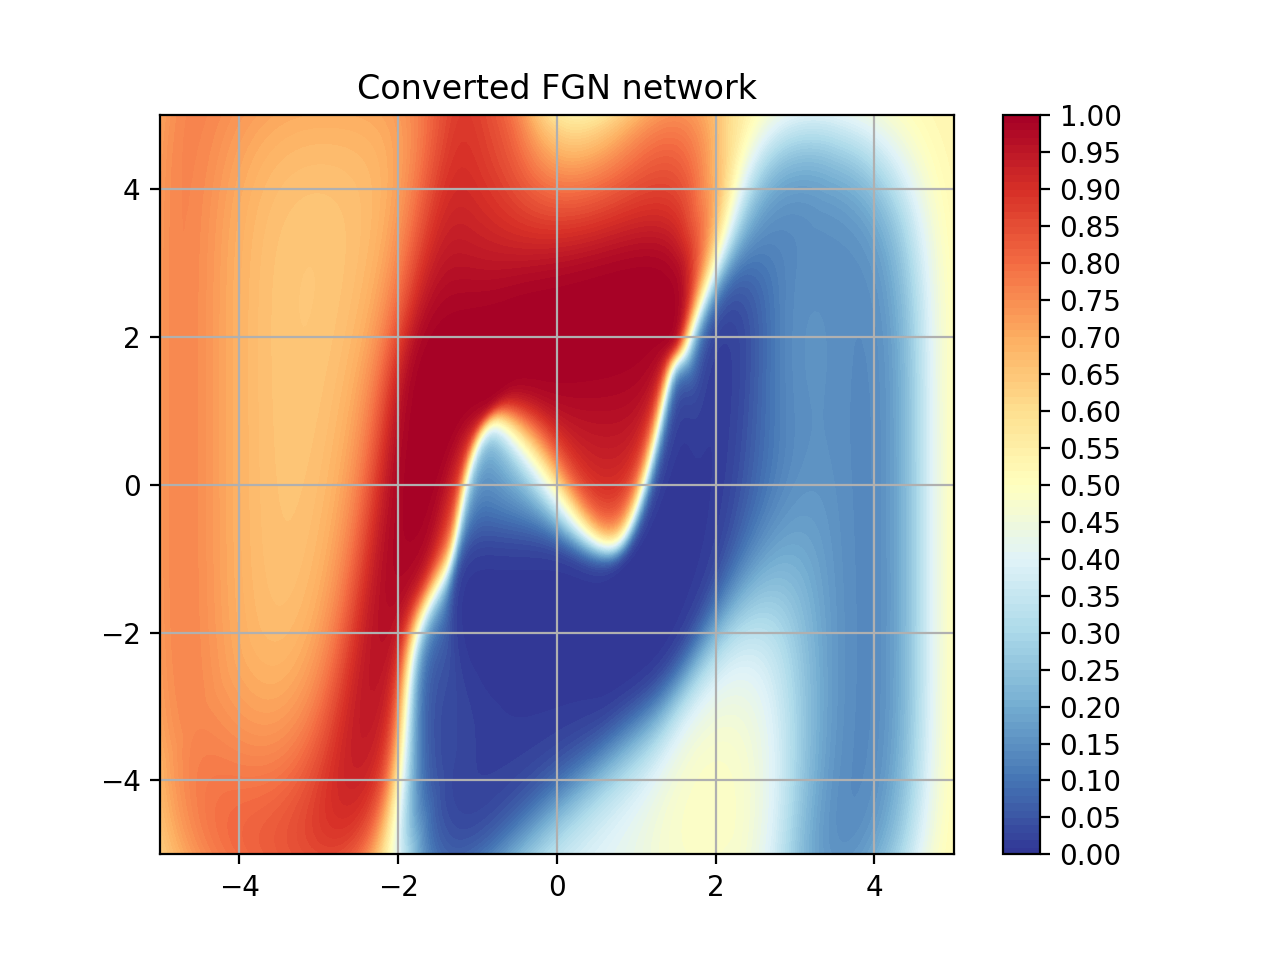

<IPython.core.display.Javascript object>


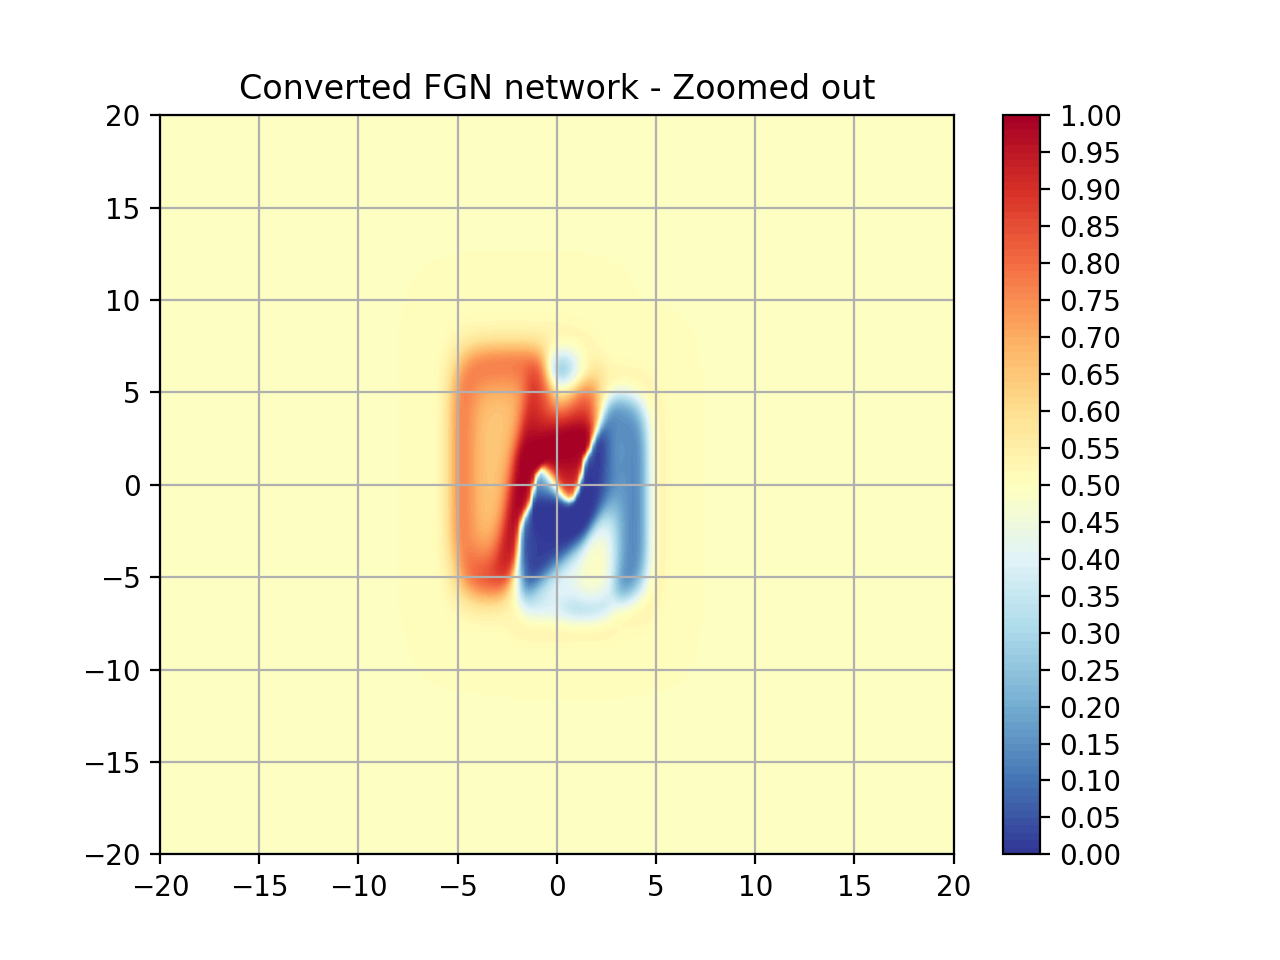

In [35]:
fgnh.plot_2D_heatmap(fgn_model, title="Converted FGN network", scale=5,  type='first',
                     show_data=False)
fgnh.plot_2D_heatmap(fgn_model, title="Converted FGN network - Zoomed out", scale=20.,  type='first',
                     show_data=False)

In [36]:
# # old random eval code
# fgn_model.set_random_eval(True)
# fgnh.plot_2D_heatmap(fgn_model, title="Converted and sigma adjusted FGN network - random eval ON")
# fgnh.plot_2D_heatmap(fgn_model, title="Converted and sigma adjusted FGN network\n Zoomed out- random eval ON", scale=100.0)
# fgnh.plot_2D_heatmap(fgn_model, title="Converted and sigma adjusted FGN network\n Super Zoomed out - random eval ON", scale=10000.0)

In [37]:
# old, uses a function
# fgnl.adjust_sigma_pred_func(converted_fgn_model, my_dataloader, fgnh.cross_ent_pred_accuracy, verbose=True)

In [38]:
# # make sure performance after isnt crap
# fgn_test_res_post = fgnh.test(converted_fgn_model, my_dataloader, 
#                      fgn_cross_ent_loss, verbose=True, 
#                      pred_func=fgnh.cross_ent_pred_accuracy)

In [39]:
# # compute predictions
# converted_fgn_model.eval()
# converted_fgn_heatmap_preds_post = converted_fgn_model(heatmap_inputs.to(device))
# converted_fgn_heatmap_preds_post = converted_fgn_heatmap_preds_post.cpu().detach().numpy()
# # apply softmax for probs
# converted_fgn_heatmap_preds_post_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in converted_fgn_heatmap_preds_post.astype('float128')])

In [40]:
# levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
# ticks = levels[::5]

# plt.contourf(X1s, X2s, np.reshape(converted_fgn_heatmap_preds_post_softmax[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
# plt.colorbar(ticks=ticks)

# # # uncomment if you want to see the data and tighten the window
# # plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# # plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# # plt.axis([-1.5,2.5, -1, 1.5])


# plt.grid(True)
# plt.show()

In [41]:
# %%timeit N=3
# _ = fgnh.train(fgn_model, my_dataloader, 
#                              adjust_sigmas_loss, adjust_sigmas_optimizer, epochs=1, save_hist=2, verbose=True, 
#                              pred_func=fgnh.cross_ent_pred_accuracy)

In [42]:
# %%timeit N=3
# _ = fgnh.test(fgn_model, my_dataloader, adjust_sigmas_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)